# Feature Engineering

##### Importación de librerías

In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import re

##### Configuración de visualización

In [26]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

##### Carga de dataset

In [27]:
csv_ubi = Path("../data/Titanic_Dataset_Imputado.csv")
df = pd.read_csv(csv_ubi)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Age_Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,F0,S,0,18-34
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,35-59
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,F0,S,0,18-34
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,18-34
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,F0,S,0,18-34


##### Feature 1 - Título (Title)
Los títulos en los nombres reflejan estatus social, estado civil y edad aproximada.

In [28]:
def extract_title(name):
    if not isinstance(name, str):
        return "Unknown"

    match = re.search(r', \s*([^\.]+)\.', name)
    if not match:
        return "Unknown"
    
    return match.group(1).strip()

all_titles = df['Name'].apply(extract_title).unique()
print("Títulos únicos encontrados en el dataset:")
print(sorted(all_titles))

def create_title_mapping(titles):
    main_titles = {"Mr", "Mrs", "Miss", "Master"}
    
    variations = {
        "Mlle": "Miss",
        "Ms": "Miss",
        "Mme": "Mrs",
    }

    title_mapping = {}

    for title in titles:
        if title in main_titles:
            title_mapping[title] = title
        elif title in variations:
            title_mapping[title] = variations[title]
        else: title_mapping[title] = "Rare"

    return title_mapping

title_mapping = create_title_mapping(all_titles)
print("\nMapeo generado automáticamente:")
for original, mapped in sorted(title_mapping.items()):
    print(f"'{original}' -> '{mapped}'")

Títulos únicos encontrados en el dataset:
['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']

Mapeo generado automáticamente:
'Capt' -> 'Rare'
'Col' -> 'Rare'
'Don' -> 'Rare'
'Dr' -> 'Rare'
'Jonkheer' -> 'Rare'
'Lady' -> 'Rare'
'Major' -> 'Rare'
'Master' -> 'Master'
'Miss' -> 'Miss'
'Mlle' -> 'Miss'
'Mme' -> 'Mrs'
'Mr' -> 'Mr'
'Mrs' -> 'Mrs'
'Ms' -> 'Miss'
'Rev' -> 'Rare'
'Sir' -> 'Rare'
'the Countess' -> 'Rare'


In [29]:
def extract_and_map_title(name, mapping):
    if not isinstance(name, str):
        return "Unknown"
    
    match = re.search(r',\s*([^\.]+)\.', name)
    if not match:
        return "Unknown"
    
    title = match.group(1).strip()
    return mapping.get(title, "Rare")
df['Title'] = df['Name'].apply(lambda x: extract_and_map_title(x, title_mapping))

print("Distribución final de títulos:")
print(df['Title'].value_counts())

Distribución final de títulos:
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


##### Feature 2: Tamaño de la familia (Family Size)

El tamaño de la familia puede influir en la supervivencia, ya que las familias más grandes pueden tener patrones diferentes de supervivencia.

=== ANÁLISIS DE FEATURE: FAMILY SIZE ===
Rango: 1 - 11
Distribución:
FamilySize
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: count, dtype: int64

Tasa de supervivencia por tamaño de familia:
            Count  Survival_Rate
FamilySize                      
1             537          0.304
2             161          0.553
3             102          0.578
4              29          0.724
5              15          0.200
6              22          0.136
7              12          0.333
8               6          0.000
11              7          0.000


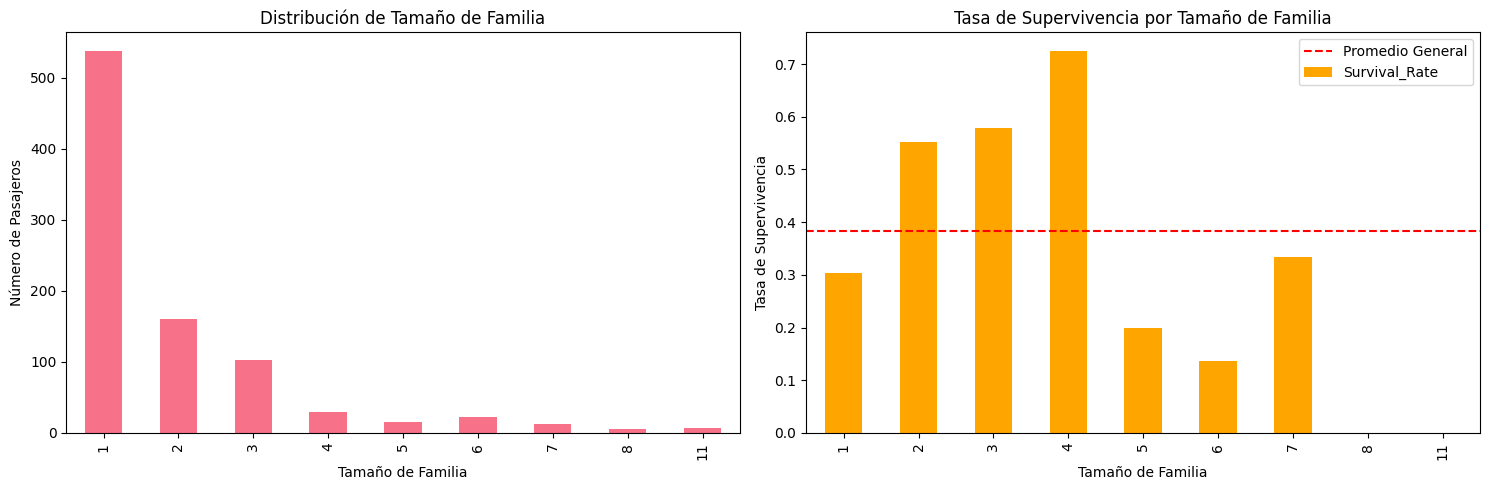

In [30]:
def compute_family_size(sibsp, parch):
    try:
        return int(sibsp) + int(parch) + 1
    except (ValueError, TypeError):
        s = pd.to_numeric(pd.Series([sibsp]), errors='coerce').iloc[0]
        p = pd.to_numeric(pd.Series([parch]), errors='coerce').iloc[0]
        s = 0 if pd.isna(s) else int(s)
        p = 0 if pd.isna(p) else int(p)
        return s + p + 1

df['FamilySize'] = [compute_family_size(s, p) for s, p in zip(df['SibSp'], df['Parch'])]

print("=== ANÁLISIS DE FEATURE: FAMILY SIZE ===")
print(f"Rango: {df['FamilySize'].min()} - {df['FamilySize'].max()}")
print(f"Distribución:")
family_counts = df['FamilySize'].value_counts().sort_index()
print(family_counts)

if 'Survived' in df.columns:
    survival_by_family = df.groupby('FamilySize')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_family.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por tamaño de familia:")
    print(survival_by_family)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    family_counts.plot(kind='bar', ax=ax1)
    ax1.set_title('Distribución de Tamaño de Familia')
    ax1.set_xlabel('Tamaño de Familia')
    ax1.set_ylabel('Número de Pasajeros')

    survival_by_family['Survival_Rate'].plot(kind='bar', ax=ax2, color='orange')
    ax2.set_title('Tasa de Supervivencia por Tamaño de Familia')
    ax2.set_xlabel('Tamaño de Familia')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

##### Feature 3: Viajero solo (isAlone)
Personas que viajan solas igualmente pueden tener diferentes patrones de supervivencia, y pueden ser más vulnerables en situaciones de emergencia.

=== ANÁLISIS DE FEATURE: IS ALONE ===
Distribución:
Viajan acompañados (0): 354
Viajan solos (1): 537
Porcentaje que viaja solo: 60.3%

Tasa de supervivencia por tipo de viaje:
            Count  Survival_Rate
Acompañado    354          0.506
Solo          537          0.304


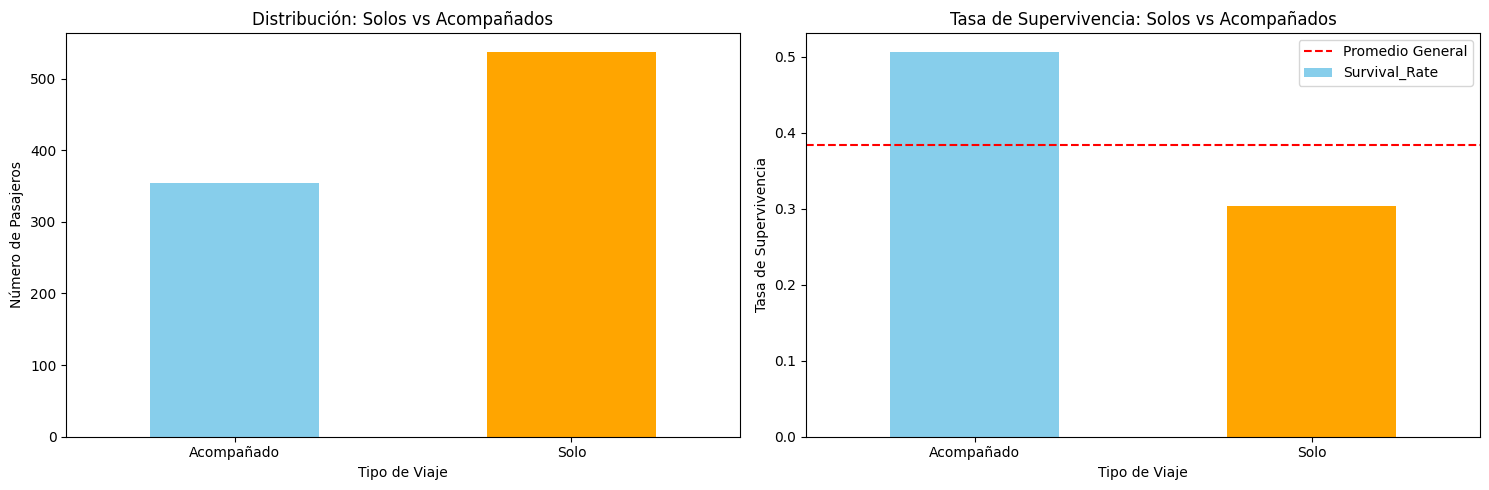


Verificación cruzada con FamilySize:
IsAlone       0    1  All
FamilySize               
1             0  537  537
2           161    0  161
3           102    0  102
4            29    0   29
5            15    0   15
6            22    0   22
7            12    0   12
8             6    0    6
11            7    0    7
All         354  537  891


In [31]:
def compute_is_alone(family_size):
    try:
        return 1 if int(family_size) == 1 else 0
    except (ValueError, TypeError):
        return 0

df['IsAlone'] = df['FamilySize'].apply(compute_is_alone)

print("=== ANÁLISIS DE FEATURE: IS ALONE ===")
print(f"Distribución:")
alone_counts = df['IsAlone'].value_counts().sort_index()
print(f"Viajan acompañados (0): {alone_counts[0]}")
print(f"Viajan solos (1): {alone_counts[1]}")
print(f"Porcentaje que viaja solo: {(alone_counts[1] / len(df)) * 100:.1f}%")

if 'Survived' in df.columns:
    survival_by_alone = df.groupby('IsAlone')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_alone.columns = ['Count', 'Survival_Rate']
    survival_by_alone.index = ['Acompañado', 'Solo']
    print(f"\nTasa de supervivencia por tipo de viaje:")
    print(survival_by_alone)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    alone_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'orange'])
    ax1.set_title('Distribución: Solos vs Acompañados')
    ax1.set_xlabel('Tipo de Viaje')
    ax1.set_ylabel('Número de Pasajeros')
    ax1.set_xticklabels(['Acompañado', 'Solo'], rotation=0)

    survival_by_alone['Survival_Rate'].plot(kind='bar', ax=ax2, color=['skyblue', 'orange'])
    ax2.set_title('Tasa de Supervivencia: Solos vs Acompañados')
    ax2.set_xlabel('Tipo de Viaje')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    ax2.set_xticklabels(['Acompañado', 'Solo'], rotation=0)
    
    plt.tight_layout()
    plt.show()

print(f"\nVerificación cruzada con FamilySize:")
cross_check = pd.crosstab(df['FamilySize'], df['IsAlone'], margins=True)
print(cross_check)

##### Feature 4: Grupos de edad (AgeGroup)
La población de diferentes edades igualmente pueden presentar un patrón de supervivencia diferente, ya que los niños, adultos y ancianos pueden tener diferentes niveles de vulnerabilidad y habilidades ante situaciones de emergencia.

=== ANÁLISIS DE FEATURE: AGE GROUP ===
Distribución:
AgeGroup
YoungAdult    409
Adult         254
MidAge         89
Child          54
Teen           45
Senior         26
Infant         14
Name: count, dtype: int64

Estadísticas de edad por grupo:
            count   min   max  mean
AgeGroup                           
Adult         254  30.0  44.0  35.8
Child          54   2.0  11.0   5.6
Infant         14   0.4   1.0   0.9
MidAge         89  45.0  59.0  50.4
Senior         26  60.0  80.0  65.1
Teen           45  12.0  17.0  15.7
YoungAdult    409  18.0  29.0  23.6

Tasa de supervivencia por grupo de edad:
            Count  Survival_Rate
AgeGroup                        
Infant         14          0.857
Child          54          0.500
Teen           45          0.489
Adult         254          0.421
MidAge         89          0.404
YoungAdult    409          0.320
Senior         26          0.269


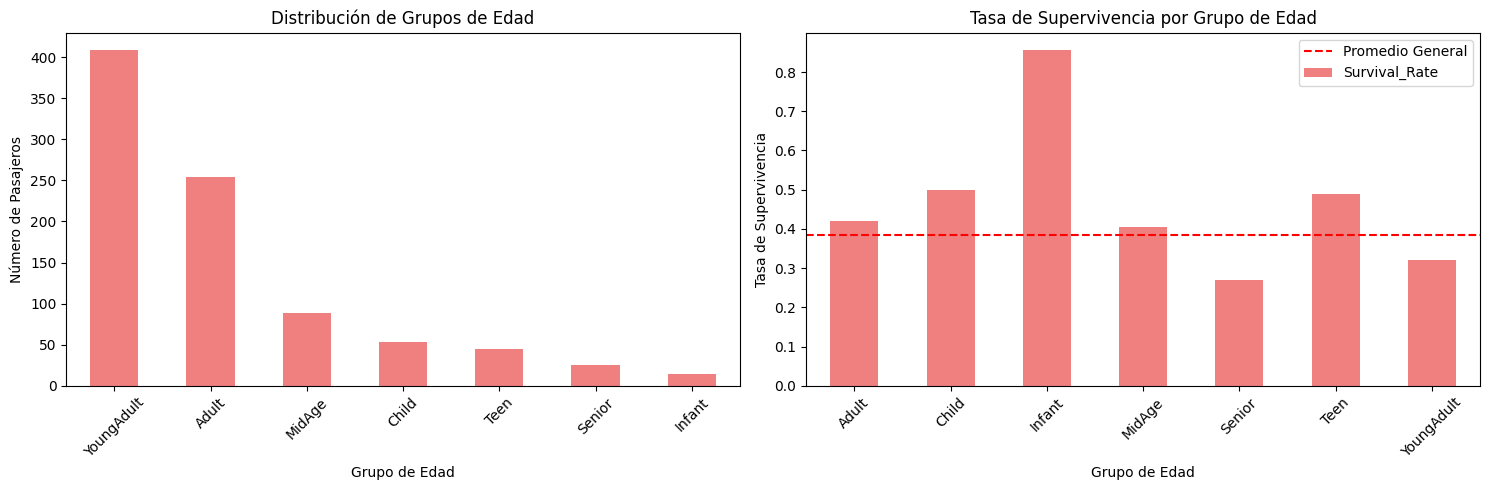


Análisis de valores faltantes en Age:
Valores faltantes: 0 (0.0%)
Asignados a 'Unknown': 0


In [32]:
def age_to_group(age):
    age_numeric = pd.to_numeric(pd.Series([age]), errors='coerce').iloc[0]
    
    if pd.isna(age_numeric):
        return "Unknown"
    
    if age_numeric < 2:
        return "Infant"
    elif age_numeric < 12:
        return "Child"
    elif age_numeric < 18:
        return "Teen"
    elif age_numeric < 30:
        return "YoungAdult"
    elif age_numeric < 45:
        return "Adult"
    elif age_numeric < 60:
        return "MidAge"
    else:
        return "Senior"

df['AgeGroup'] = df['Age'].apply(age_to_group)

print("=== ANÁLISIS DE FEATURE: AGE GROUP ===")
print(f"Distribución:")
age_group_counts = df['AgeGroup'].value_counts()
print(age_group_counts)

print(f"\nEstadísticas de edad por grupo:")
age_stats = df.groupby('AgeGroup')['Age'].agg(['count', 'min', 'max', 'mean']).round(1)
print(age_stats)

if 'Survived' in df.columns:
    survival_by_age_group = df.groupby('AgeGroup')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_age_group.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por grupo de edad:")
    print(survival_by_age_group.sort_values('Survival_Rate', ascending=False))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    age_group_counts.plot(kind='bar', ax=ax1, color='lightcoral')
    ax1.set_title('Distribución de Grupos de Edad')
    ax1.set_xlabel('Grupo de Edad')
    ax1.set_ylabel('Número de Pasajeros')
    ax1.tick_params(axis='x', rotation=45)

    survival_by_age_group['Survival_Rate'].plot(kind='bar', ax=ax2, color='lightcoral')
    ax2.set_title('Tasa de Supervivencia por Grupo de Edad')
    ax2.set_xlabel('Grupo de Edad')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

print(f"\nAnálisis de valores faltantes en Age:")
print(f"Valores faltantes: {df['Age'].isna().sum()} ({(df['Age'].isna().sum()/len(df))*100:.1f}%)")
print(f"Asignados a 'Unknown': {(df['AgeGroup'] == 'Unknown').sum()}")

##### Feature 5: Tarifa por persona (FarePerPerson)
Nos apoyaría en la definición de grupos socioeconómicos entre la población y con la posibilidad de saber en cuál de las zonas del barco se encontraba cada uno.

=== ANÁLISIS DE FEATURE: FARE PER PERSON ===
Estadísticas descriptivas:
count    891.00
mean      17.79
std       21.22
min        0.00
25%        7.76
50%        8.85
75%       24.29
max      221.78
Name: FarePerPerson, dtype: float64

Comparación Fare vs FarePerPerson:
       Fare_Original  FarePerPerson
count         891.00         891.00
mean           32.20          17.79
std            49.69          21.22
min             0.00           0.00
25%             7.91           7.76
50%            14.45           8.85
75%            31.00          24.29
max           512.33         221.78

Ejemplos de tickets compartidos:
                                                 Name   Ticket     Fare  \
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)   113803  53.1000   
7                      Palsson, Master. Gosta Leonard   349909  21.0750   
8   Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   347742  11.1333   
9                 Nasser, Mrs. Nicholas (Adele Achem)   237736  30.070

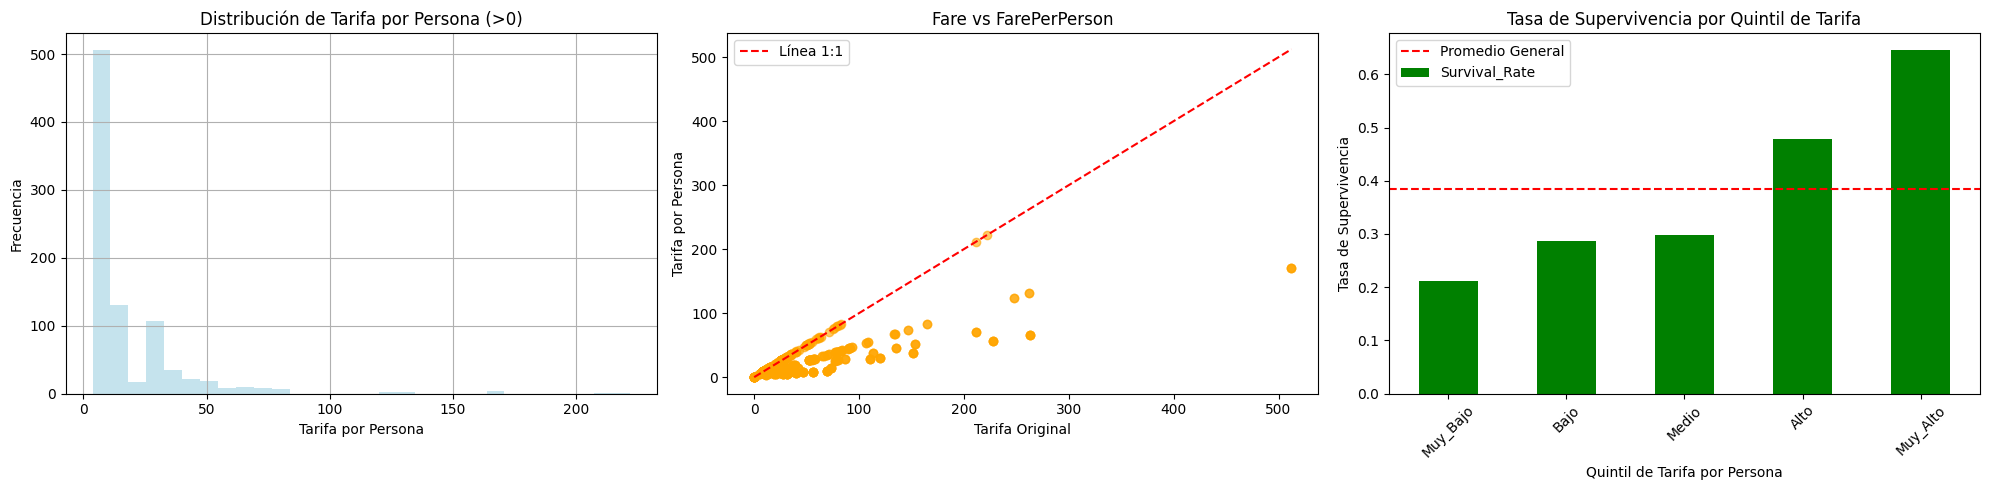


Análisis de tickets compartidos:
   Personas_por_Ticket  Num_Tickets
0                    1          547
1                    2          188
2                    3           63
3                    4           44
4                    5           10
5                    6           18
6                    7           21


In [33]:
def compute_ticket_frequency(df):
    return df['Ticket'].value_counts().to_dict()

def compute_fare_per_person(fare, ticket, ticket_freq_dict):
    try:
        fare_numeric = pd.to_numeric(pd.Series([fare]), errors='coerce').iloc[0]

        if pd.isna(fare_numeric) or fare_numeric == 0:
            return 0.0

        people_sharing = ticket_freq_dict.get(ticket, 1)

        return fare_numeric / people_sharing
        
    except Exception:
        return 0.0

ticket_frequencies = compute_ticket_frequency(df)

df['FarePerPerson'] = [
    compute_fare_per_person(fare, ticket, ticket_frequencies) 
    for fare, ticket in zip(df['Fare'], df['Ticket'])
]

print("=== ANÁLISIS DE FEATURE: FARE PER PERSON ===")
print(f"Estadísticas descriptivas:")
fare_stats = df['FarePerPerson'].describe().round(2)
print(fare_stats)

print(f"\nComparación Fare vs FarePerPerson:")
comparison = pd.DataFrame({
    'Fare_Original': df['Fare'].describe().round(2),
    'FarePerPerson': df['FarePerPerson'].describe().round(2)
})
print(comparison)

print(f"\nEjemplos de tickets compartidos:")
shared_tickets = df[df['Ticket'].map(ticket_frequencies) > 1][['Name', 'Ticket', 'Fare', 'FarePerPerson']].head(10)
print(shared_tickets)

print(f"\nAnálisis de calidad:")
print(f"Valores cero en Fare original: {(df['Fare'] == 0).sum()}")
print(f"Valores cero en FarePerPerson: {(df['FarePerPerson'] == 0).sum()}")
print(f"Valores faltantes en Fare: {df['Fare'].isna().sum()}")
print(f"Valores faltantes en FarePerPerson: {df['FarePerPerson'].isna().sum()}")

if 'Survived' in df.columns:
    fare_non_zero = df[df['FarePerPerson'] > 0]['FarePerPerson']
    
    if len(fare_non_zero) > 0:
        df['FarePerPerson_Quintile'] = pd.qcut(
            df['FarePerPerson'].rank(method='first'), 
            q=5, 
            labels=['Muy_Bajo', 'Bajo', 'Medio', 'Alto', 'Muy_Alto'],
            duplicates='drop'
        )
        
        survival_by_fare = df.groupby('FarePerPerson_Quintile')['Survived'].agg(['count', 'mean']).round(3)
        survival_by_fare.columns = ['Count', 'Survival_Rate']
        print(f"\nTasa de supervivencia por quintil de tarifa por persona:")
        print(survival_by_fare)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
        
        df[df['FarePerPerson'] > 0]['FarePerPerson'].hist(bins=30, ax=ax1, color='lightblue', alpha=0.7)
        ax1.set_title('Distribución de Tarifa por Persona (>0)')
        ax1.set_xlabel('Tarifa por Persona')
        ax1.set_ylabel('Frecuencia')

        ax2.scatter(df['Fare'], df['FarePerPerson'], alpha=0.6, color='orange')
        ax2.plot([0, df['Fare'].max()], [0, df['Fare'].max()], 'r--', label='Línea 1:1')
        ax2.set_xlabel('Tarifa Original')
        ax2.set_ylabel('Tarifa por Persona')
        ax2.set_title('Fare vs FarePerPerson')
        ax2.legend()

        if 'FarePerPerson_Quintile' in df.columns:
            survival_by_fare['Survival_Rate'].plot(kind='bar', ax=ax3, color='green')
            ax3.set_title('Tasa de Supervivencia por Quintil de Tarifa')
            ax3.set_xlabel('Quintil de Tarifa por Persona')
            ax3.set_ylabel('Tasa de Supervivencia')
            ax3.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
            ax3.legend()
            ax3.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

print(f"\nAnálisis de tickets compartidos:")
ticket_sharing_analysis = pd.DataFrame({
    'Personas_por_Ticket': df['Ticket'].map(ticket_frequencies),
    'Count': df['Ticket'].map(ticket_frequencies)
}).groupby('Personas_por_Ticket').size().reset_index()
ticket_sharing_analysis.columns = ['Personas_por_Ticket', 'Num_Tickets']
print(ticket_sharing_analysis.head(10))

##### Feature 6: Frecuencia de Ticket (TicketFrequency)

Nos indica cuántas personas comparten el mismo ticket, lo que puede revelar grupos familiares o de viaje que no son detectados por SibSp/Parch.

=== ANÁLISIS DE FEATURE: TICKET FREQUENCY ===
Estadísticas descriptivas:
count    891.00
mean       1.79
std        1.36
min        1.00
25%        1.00
50%        1.00
75%        2.00
max        7.00
Name: TicketFrequency, dtype: float64

Distribución de frecuencias de ticket:
TicketFrequency
1    547
2    188
3     63
4     44
5     10
6     18
7     21
Name: count, dtype: int64

Ejemplos de tickets compartidos:

Tickets compartidos por 2 personas:
                                        Name  Ticket  FamilySize  TicketFrequency
Futrelle, Mrs. Jacques Heath (Lily May Peel)  113803           2                2
         Nasser, Mrs. Nicholas (Adele Achem)  237736           2                2
             Sandstrom, Miss. Marguerite Rut PP 9549           3                2

Tickets compartidos por 3 personas:
                                             Name        Ticket  FamilySize  TicketFrequency
Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)        347742           3            

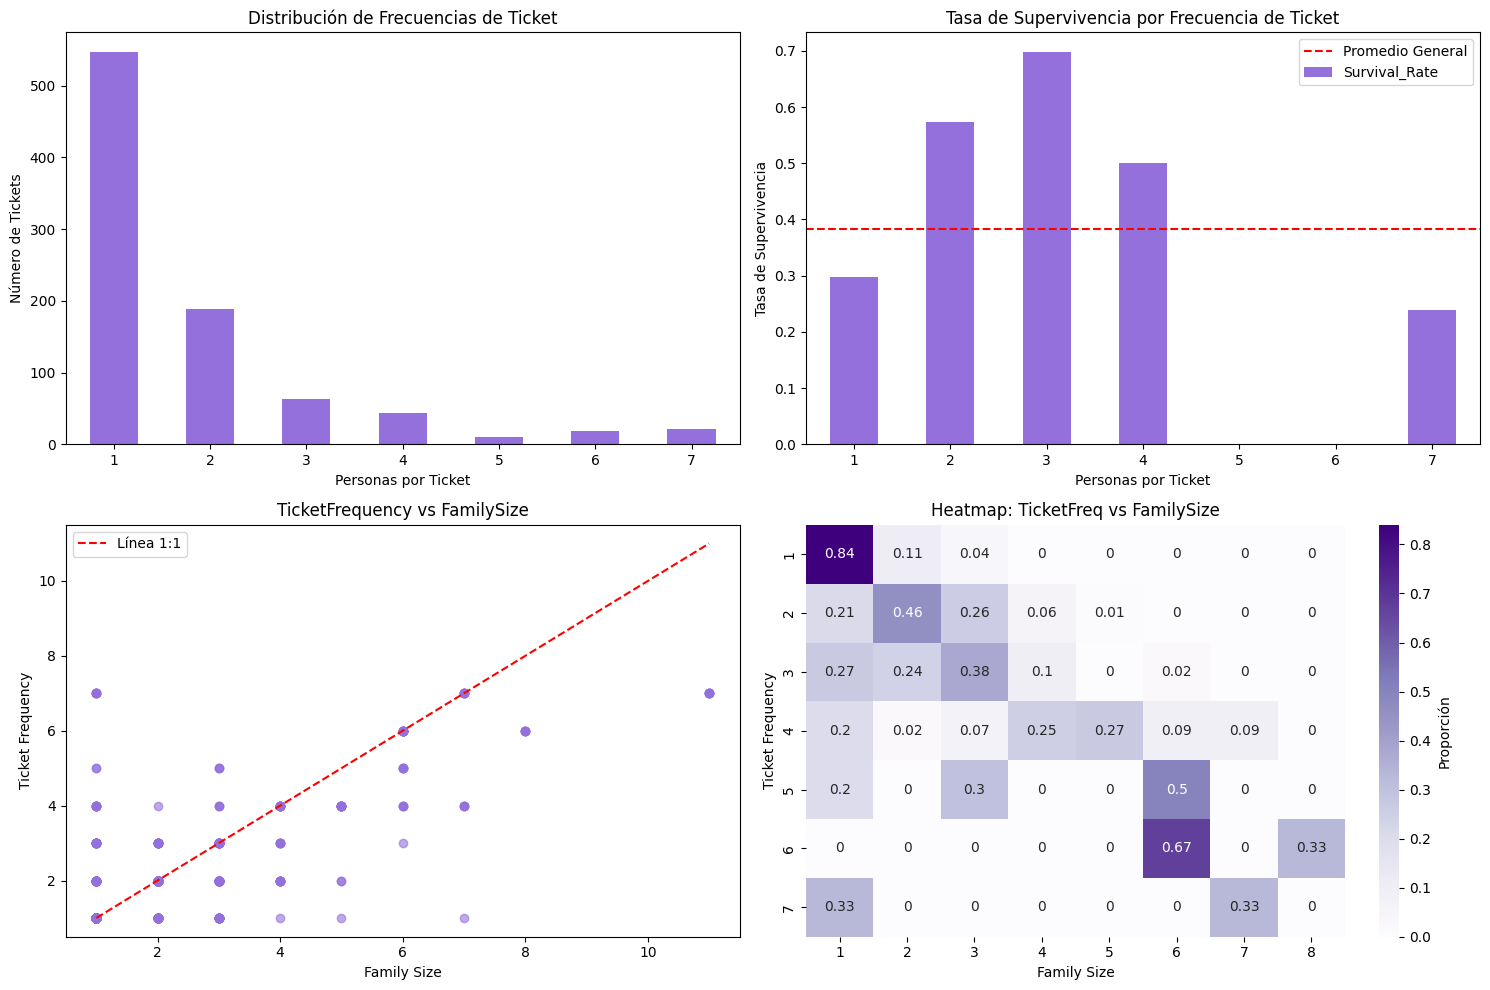


Análisis de calidad:
Valores faltantes: 0
Valores únicos: 7
Rango: 1 - 7

Distribución por categorías de ticket:
TicketFreq_Category
Individual       547
Pareja           188
Grupo_Pequeño    107
Grupo_Mediano     28
Grupo_Grande      21
Name: count, dtype: int64

Tasa de supervivencia por categoría de ticket:
                     Count  Survival_Rate
TicketFreq_Category                      
Grupo_Pequeño          107          0.617
Pareja                 188          0.574
Individual             547          0.298
Grupo_Grande            21          0.238
Grupo_Mediano           28          0.000


In [34]:
def compute_ticket_frequency_feature(ticket, ticket_freq_dict):
    try:
        return ticket_freq_dict.get(ticket, 1)
    except Exception:
        return 1

df['TicketFrequency'] = df['Ticket'].map(ticket_frequencies)

print("=== ANÁLISIS DE FEATURE: TICKET FREQUENCY ===")
print(f"Estadísticas descriptivas:")
ticket_freq_stats = df['TicketFrequency'].describe().round(2)
print(ticket_freq_stats)

print(f"\nDistribución de frecuencias de ticket:")
ticket_freq_counts = df['TicketFrequency'].value_counts().sort_index()
print(ticket_freq_counts.head(10))

print(f"\nEjemplos de tickets compartidos:")
for freq in [2, 3, 4, 5]:
    if freq in df['TicketFrequency'].values:
        examples = df[df['TicketFrequency'] == freq][['Name', 'Ticket', 'FamilySize', 'TicketFrequency']].head(3)
        print(f"\nTickets compartidos por {freq} personas:")
        print(examples.to_string(index=False))

print(f"\nComparación TicketFrequency vs FamilySize:")
comparison_table = pd.crosstab(df['TicketFrequency'], df['FamilySize'], margins=True)
print(comparison_table)

print(f"\nAnálisis de discrepancias (TicketFreq != FamilySize):")
discrepancies = df[df['TicketFrequency'] != df['FamilySize']]
print(f"Casos donde difieren: {len(discrepancies)} ({(len(discrepancies)/len(df))*100:.1f}%)")

if len(discrepancies) > 0:
    print(f"\nEjemplos de discrepancias:")
    disc_examples = discrepancies[['Name', 'Ticket', 'SibSp', 'Parch', 'FamilySize', 'TicketFrequency']].head(5)
    print(disc_examples.to_string(index=False))

if 'Survived' in df.columns:
    survival_by_ticket_freq = df.groupby('TicketFrequency')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_ticket_freq.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por frecuencia de ticket:")
    print(survival_by_ticket_freq.head(10))
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    ticket_freq_counts.head(10).plot(kind='bar', ax=ax1, color='mediumpurple')
    ax1.set_title('Distribución de Frecuencias de Ticket')
    ax1.set_xlabel('Personas por Ticket')
    ax1.set_ylabel('Número de Tickets')
    ax1.tick_params(axis='x', rotation=0)
    
    survival_by_ticket_freq['Survival_Rate'].head(8).plot(kind='bar', ax=ax2, color='mediumpurple')
    ax2.set_title('Tasa de Supervivencia por Frecuencia de Ticket')
    ax2.set_xlabel('Personas por Ticket')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=0)
    
    ax3.scatter(df['FamilySize'], df['TicketFrequency'], alpha=0.6, color='mediumpurple')
    ax3.plot([1, df['FamilySize'].max()], [1, df['FamilySize'].max()], 'r--', label='Línea 1:1')
    ax3.set_xlabel('Family Size')
    ax3.set_ylabel('Ticket Frequency')
    ax3.set_title('TicketFrequency vs FamilySize')
    ax3.legend()
    
    comparison_pct = pd.crosstab(df['TicketFrequency'], df['FamilySize'], normalize='index').round(2)
    sns.heatmap(comparison_pct.iloc[:8, :8], annot=True, cmap='Purples', ax=ax4, 
                cbar_kws={'label': 'Proporción'})
    ax4.set_title('Heatmap: TicketFreq vs FamilySize')
    ax4.set_xlabel('Family Size')
    ax4.set_ylabel('Ticket Frequency')
    
    plt.tight_layout()
    plt.show()

print(f"\nAnálisis de calidad:")
print(f"Valores faltantes: {df['TicketFrequency'].isna().sum()}")
print(f"Valores únicos: {df['TicketFrequency'].nunique()}")
print(f"Rango: {df['TicketFrequency'].min()} - {df['TicketFrequency'].max()}")

def categorize_ticket_frequency(freq):
    if freq == 1:
        return "Individual"
    elif freq == 2:
        return "Pareja"
    elif freq <= 4:
        return "Grupo_Pequeño"
    elif freq <= 6:
        return "Grupo_Mediano"
    else:
        return "Grupo_Grande"

df['TicketFreq_Category'] = df['TicketFrequency'].apply(categorize_ticket_frequency)

print(f"\nDistribución por categorías de ticket:")
ticket_cat_counts = df['TicketFreq_Category'].value_counts()
print(ticket_cat_counts)

if 'Survived' in df.columns:
    survival_by_ticket_cat = df.groupby('TicketFreq_Category')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_ticket_cat.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por categoría de ticket:")
    print(survival_by_ticket_cat.sort_values('Survival_Rate', ascending=False))

##### Feature 7: CabinDeck - Letra de la cabina
La primera letra de la cabina indica la cubierta donde se encontraba el pasajero, lo cual está directamente relacionado con el acceso a los botes salvavidas.

=== ANÁLISIS DE FEATURE: CABIN DECK ===
Distribución de cubiertas:
CabinDeck
F    660
C     99
B     47
D     33
E     32
A     15
G      4
T      1
Name: count, dtype: int64

Ejemplos de cabinas por cubierta:
Cubierta A: ['A6', 'A5', 'A7']
Cubierta B: ['B78', 'B30', 'B28']
Cubierta C: ['C85', 'C123', 'C103']
Cubierta D: ['D56', 'D33', 'D10 D12']
Cubierta E: ['E46', 'E31', 'E101']
Cubierta F: ['F0', 'F0', 'F0']

Tasa de supervivencia por cubierta:
           Count  Survival_Rate
CabinDeck                      
D             33          0.758
E             32          0.750
B             47          0.745
C             99          0.545
G              4          0.500
A             15          0.467
F            660          0.295
T              1          0.000

Distribución de cubiertas por clase:
Pclass       1    2    3  All
CabinDeck                    
A           15    0    0   15
B           47    0    0   47
C           99    0    0   99
D           29    4    0   33
E         

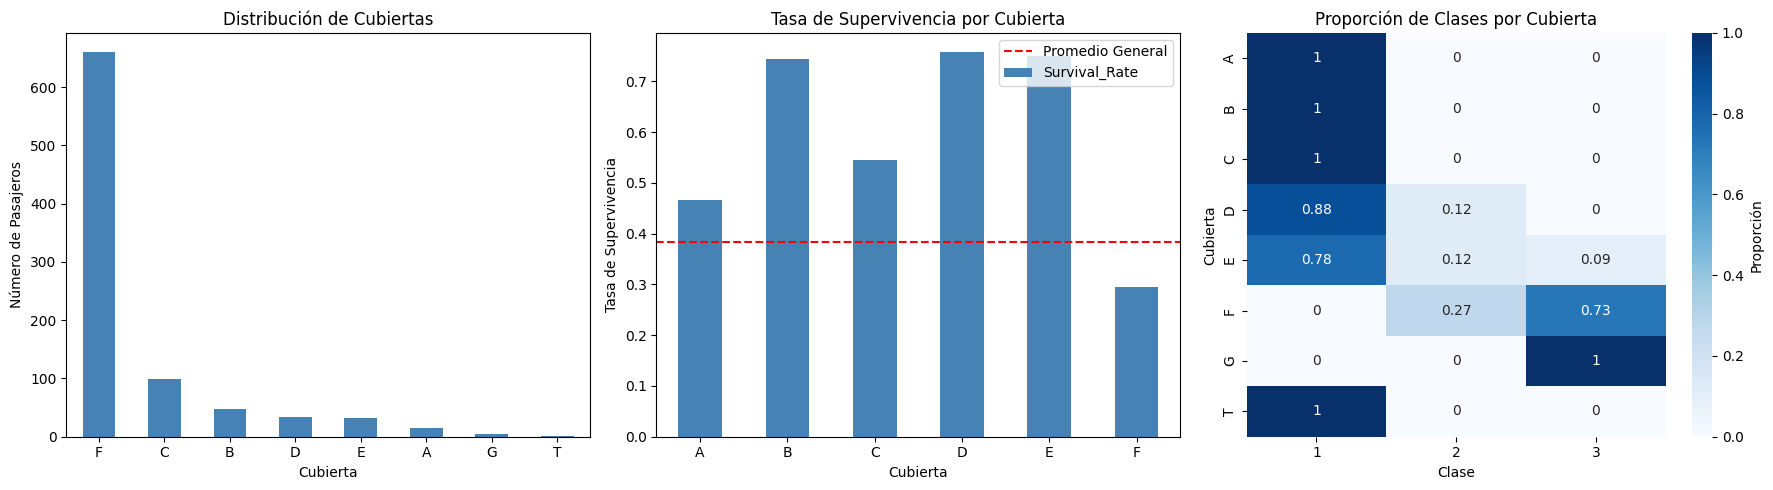


Análisis de calidad:
Cubiertas conocidas: 891 (100.0%)
Cubiertas desconocidas: 0 (0.0%)


In [35]:
def extract_cabin_deck(cabin):
    """
    Extrae la primera letra de la cabina que indica la cubierta
    """
    if pd.isna(cabin) or cabin == 'NaN' or not isinstance(cabin, str):
        return 'Unknown'
    
    # Limpiar la cabina y extraer la primera letra
    cabin_clean = str(cabin).strip()
    if len(cabin_clean) == 0:
        return 'Unknown'
    
    # La primera letra es la cubierta
    deck = cabin_clean[0].upper()
    
    # Validar que sea una letra válida de cubierta
    valid_decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
    if deck in valid_decks:
        return deck
    else:
        return 'Unknown'

# Aplicar la función
df['CabinDeck'] = df['Cabin'].apply(extract_cabin_deck)

print("=== ANÁLISIS DE FEATURE: CABIN DECK ===")
print(f"Distribución de cubiertas:")
deck_counts = df['CabinDeck'].value_counts()
print(deck_counts)

print(f"\nEjemplos de cabinas por cubierta:")
for deck in ['A', 'B', 'C', 'D', 'E', 'F']:
    if deck in df['CabinDeck'].values:
        examples = df[df['CabinDeck'] == deck]['Cabin'].dropna().head(3).tolist()
        if examples:
            print(f"Cubierta {deck}: {examples}")

if 'Survived' in df.columns:
    survival_by_deck = df.groupby('CabinDeck')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_deck.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por cubierta:")
    print(survival_by_deck.sort_values('Survival_Rate', ascending=False))
    
    # Relación con clase
    deck_class_crosstab = pd.crosstab(df['CabinDeck'], df['Pclass'], margins=True)
    print(f"\nDistribución de cubiertas por clase:")
    print(deck_class_crosstab)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Distribución de cubiertas
    deck_counts.plot(kind='bar', ax=ax1, color='steelblue')
    ax1.set_title('Distribución de Cubiertas')
    ax1.set_xlabel('Cubierta')
    ax1.set_ylabel('Número de Pasajeros')
    ax1.tick_params(axis='x', rotation=0)
    
    # Supervivencia por cubierta
    survival_by_deck_filtered = survival_by_deck[survival_by_deck['Count'] >= 5]  # Solo cubiertas con suficientes datos
    survival_by_deck_filtered['Survival_Rate'].plot(kind='bar', ax=ax2, color='steelblue')
    ax2.set_title('Tasa de Supervivencia por Cubierta')
    ax2.set_xlabel('Cubierta')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=0)
    
    # Heatmap cubierta vs clase
    deck_class_pct = pd.crosstab(df['CabinDeck'], df['Pclass'], normalize='index').round(2)
    deck_class_pct = deck_class_pct[deck_class_pct.sum(axis=1) > 0.01]  # Solo cubiertas significativas
    sns.heatmap(deck_class_pct, annot=True, cmap='Blues', ax=ax3, 
                cbar_kws={'label': 'Proporción'})
    ax3.set_title('Proporción de Clases por Cubierta')
    ax3.set_xlabel('Clase')
    ax3.set_ylabel('Cubierta')
    
    plt.tight_layout()
    plt.show()

print(f"\nAnálisis de calidad:")
print(f"Cubiertas conocidas: {(df['CabinDeck'] != 'Unknown').sum()} ({(df['CabinDeck'] != 'Unknown').sum()/len(df)*100:.1f}%)")
print(f"Cubiertas desconocidas: {(df['CabinDeck'] == 'Unknown').sum()} ({(df['CabinDeck'] == 'Unknown').sum()/len(df)*100:.1f}%)")

##### Feature 8: Mother - Identificar madres
Identifica a las mujeres que viajaban con hijos, ya que las madres tenían prioridad especial en los protocolos de evacuación y motivación adicional para sobrevivir.

=== ANÁLISIS DE FEATURE: MOTHER ===
Distribución:
No madre (0): 809 (90.8%)
Madre (1): 82 (9.2%)

Análisis por sexo:
Mother    0   1  All
Sex                 
female  232  82  314
male    577   0  577
All     809  82  891

Análisis por título:
Mother    0   1  All
Title               
Master   40   0   40
Miss    159  26  185
Mr      517   0  517
Mrs      70  56  126
Rare     23   0   23
All     809  82  891

Ejemplos de madres identificadas:
                                                     Name    Sex  Age  Parch Title  FamilySize
        Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg) female 27.0      2   Mrs           3
Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson) female 38.0      5   Mrs           7
                               Fortune, Miss. Mabel Helen female 23.0      2  Miss           6
                     Doling, Mrs. John T (Ada Julia Bone) female 34.0      1   Mrs           2
                                        Peter, Miss. Anna female 21.5      1  

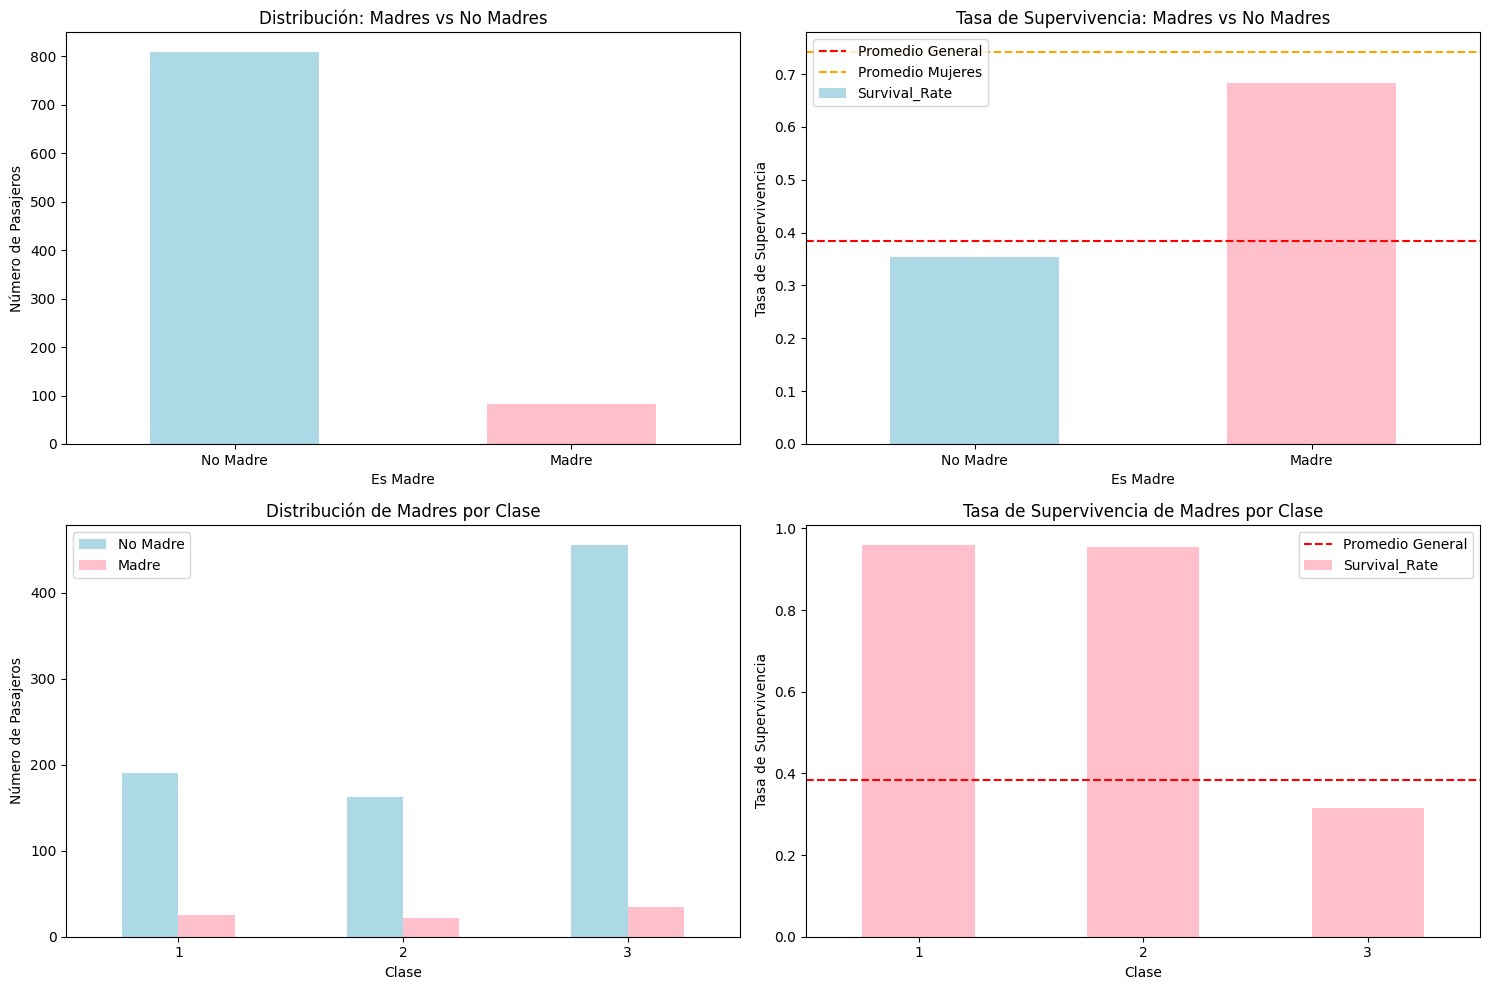


Análisis de edad de las madres:
Estadísticas de edad de las madres:
count    82.0
mean     31.6
std      10.7
min      18.0
25%      22.0
50%      29.0
75%      39.8
max      58.0
Name: Age, dtype: float64

Comparación con mujeres en general:
count    314.0
mean      27.3
std       13.1
min        0.8
25%       21.0
50%       24.0
75%       35.0
max       63.0
Name: Age, dtype: float64

Análisis del número de hijos (Parch) de las madres:
count    82.0
mean      1.8
std       1.1
min       1.0
25%       1.0
50%       1.5
75%       2.0
max       6.0
Name: Parch, dtype: float64

Distribución del número de hijos:
Parch
1    41
2    30
3     4
4     2
5     4
6     1
Name: count, dtype: int64


In [36]:
def identify_mother(sex, age, parch, title):
    """
    Identifica si una persona es madre basado en:
    - Sexo femenino
    - Edad >= 18 años (para ser considerada adulta)
    - Parch > 0 (viaja con hijos)
    - Título Mrs (preferiblemente, pero no exclusivo)
    """
    # Debe ser mujer
    if sex != 'female':
        return 0
    
    # Debe tener al menos 18 años (o edad desconocida se considera elegible)
    if pd.notna(age) and age < 18:
        return 0
    
    # Debe viajar con hijos (Parch > 0)
    if pd.isna(parch) or parch == 0:
        return 0
    
    # Si cumple los criterios básicos, es considerada madre
    return 1

# Aplicar la función
df['Mother'] = df.apply(lambda row: identify_mother(
    row['Sex'], row['Age'], row['Parch'], row['Title']
), axis=1)

print("=== ANÁLISIS DE FEATURE: MOTHER ===")
print(f"Distribución:")
mother_counts = df['Mother'].value_counts().sort_index()
print(f"No madre (0): {mother_counts[0]} ({mother_counts[0]/len(df)*100:.1f}%)")
print(f"Madre (1): {mother_counts[1]} ({mother_counts[1]/len(df)*100:.1f}%)")

print(f"\nAnálisis por sexo:")
mother_by_sex = pd.crosstab(df['Sex'], df['Mother'], margins=True)
print(mother_by_sex)

print(f"\nAnálisis por título:")
mother_by_title = pd.crosstab(df['Title'], df['Mother'], margins=True)
print(mother_by_title)

print(f"\nEjemplos de madres identificadas:")
mothers_sample = df[df['Mother'] == 1][['Name', 'Sex', 'Age', 'Parch', 'Title', 'FamilySize']].head(10)
print(mothers_sample.to_string(index=False))

if 'Survived' in df.columns:
    survival_by_mother = df.groupby('Mother')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_mother.columns = ['Count', 'Survival_Rate']
    survival_by_mother.index = ['No_Madre', 'Madre']
    print(f"\nTasa de supervivencia por condición de madre:")
    print(survival_by_mother)
    
    # Comparación con mujeres en general
    print(f"\nComparación de supervivencia:")
    women_survival = df[df['Sex'] == 'female']['Survived'].mean()
    mothers_survival = df[df['Mother'] == 1]['Survived'].mean()
    print(f"Supervivencia mujeres en general: {women_survival:.3f}")
    print(f"Supervivencia madres: {mothers_survival:.3f}")
    print(f"Diferencia: {mothers_survival - women_survival:.3f}")
    
    # Análisis por clase
    mother_class_survival = df[df['Mother'] == 1].groupby('Pclass')['Survived'].agg(['count', 'mean']).round(3)
    mother_class_survival.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia de madres por clase:")
    print(mother_class_survival)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribución de madres
    mother_counts.plot(kind='bar', ax=ax1, color=['lightblue', 'pink'])
    ax1.set_title('Distribución: Madres vs No Madres')
    ax1.set_xlabel('Es Madre')
    ax1.set_ylabel('Número de Pasajeros')
    ax1.set_xticklabels(['No Madre', 'Madre'], rotation=0)
    
    # Supervivencia por condición de madre
    survival_by_mother['Survival_Rate'].plot(kind='bar', ax=ax2, color=['lightblue', 'pink'])
    ax2.set_title('Tasa de Supervivencia: Madres vs No Madres')
    ax2.set_xlabel('Es Madre')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.axhline(y=women_survival, color='orange', linestyle='--', label='Promedio Mujeres')
    ax2.legend()
    ax2.set_xticklabels(['No Madre', 'Madre'], rotation=0)
    
    # Distribución de madres por clase
    mother_class_dist = pd.crosstab(df['Pclass'], df['Mother'])
    mother_class_dist.plot(kind='bar', ax=ax3, color=['lightblue', 'pink'], stacked=False)
    ax3.set_title('Distribución de Madres por Clase')
    ax3.set_xlabel('Clase')
    ax3.set_ylabel('Número de Pasajeros')
    ax3.legend(['No Madre', 'Madre'])
    ax3.tick_params(axis='x', rotation=0)
    
    # Supervivencia de madres por clase
    if not mother_class_survival.empty:
        mother_class_survival['Survival_Rate'].plot(kind='bar', ax=ax4, color='pink')
        ax4.set_title('Tasa de Supervivencia de Madres por Clase')
        ax4.set_xlabel('Clase')
        ax4.set_ylabel('Tasa de Supervivencia')
        ax4.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
        ax4.legend()
        ax4.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

# Análisis de edad de las madres
print(f"\nAnálisis de edad de las madres:")
if df[df['Mother'] == 1]['Age'].notna().any():
    mothers_age_stats = df[df['Mother'] == 1]['Age'].describe().round(1)
    print("Estadísticas de edad de las madres:")
    print(mothers_age_stats)
    
    women_age_stats = df[df['Sex'] == 'female']['Age'].describe().round(1)
    print("\nComparación con mujeres en general:")
    print(women_age_stats)

# Análisis del número de hijos
print(f"\nAnálisis del número de hijos (Parch) de las madres:")
mothers_parch_stats = df[df['Mother'] == 1]['Parch'].describe().round(1)
print(mothers_parch_stats)

parch_dist = df[df['Mother'] == 1]['Parch'].value_counts().sort_index()
print(f"\nDistribución del número de hijos:")
print(parch_dist)

##### Feature 9: NameLength - Longitud del nombre
La longitud del nombre completo puede ser un proxy del estatus social, ya que las personas de clase alta tendían a tener nombres más largos y elaborados en la época victoriana.

=== ANÁLISIS DE FEATURE: NAME LENGTH ===
Estadísticas descriptivas:
count    891.0
mean      27.0
std        9.3
min       12.0
25%       20.0
50%       25.0
75%       30.0
max       82.0
Name: NameLength, dtype: float64

Ejemplos de nombres por longitud:
Nombres cortos (<=20 caracteres):
  Moran, Mr. James (longitud: 16)
  Rice, Master. Eugene (longitud: 20)
  Fynney, Mr. Joseph J (longitud: 20)
  Todoroff, Mr. Lalio (longitud: 19)
  Mamee, Mr. Hanna (longitud: 16)

Nombres largos (>=60 caracteres):
  Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo) (longitud: 82)
  Phillips, Miss. Kate Florence ("Mrs Kate Louise Phillips Marshall") (longitud: 67)
  Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan") (longitud: 65)
  Brown, Mrs. Thomas William Solomon (Elizabeth Catherine Ford) (longitud: 61)

Distribución por categorías de longitud:
NameLength_Category
Corto        514
Muy_Corto    243
Medio        109
Largo         23
Muy_Largo      2


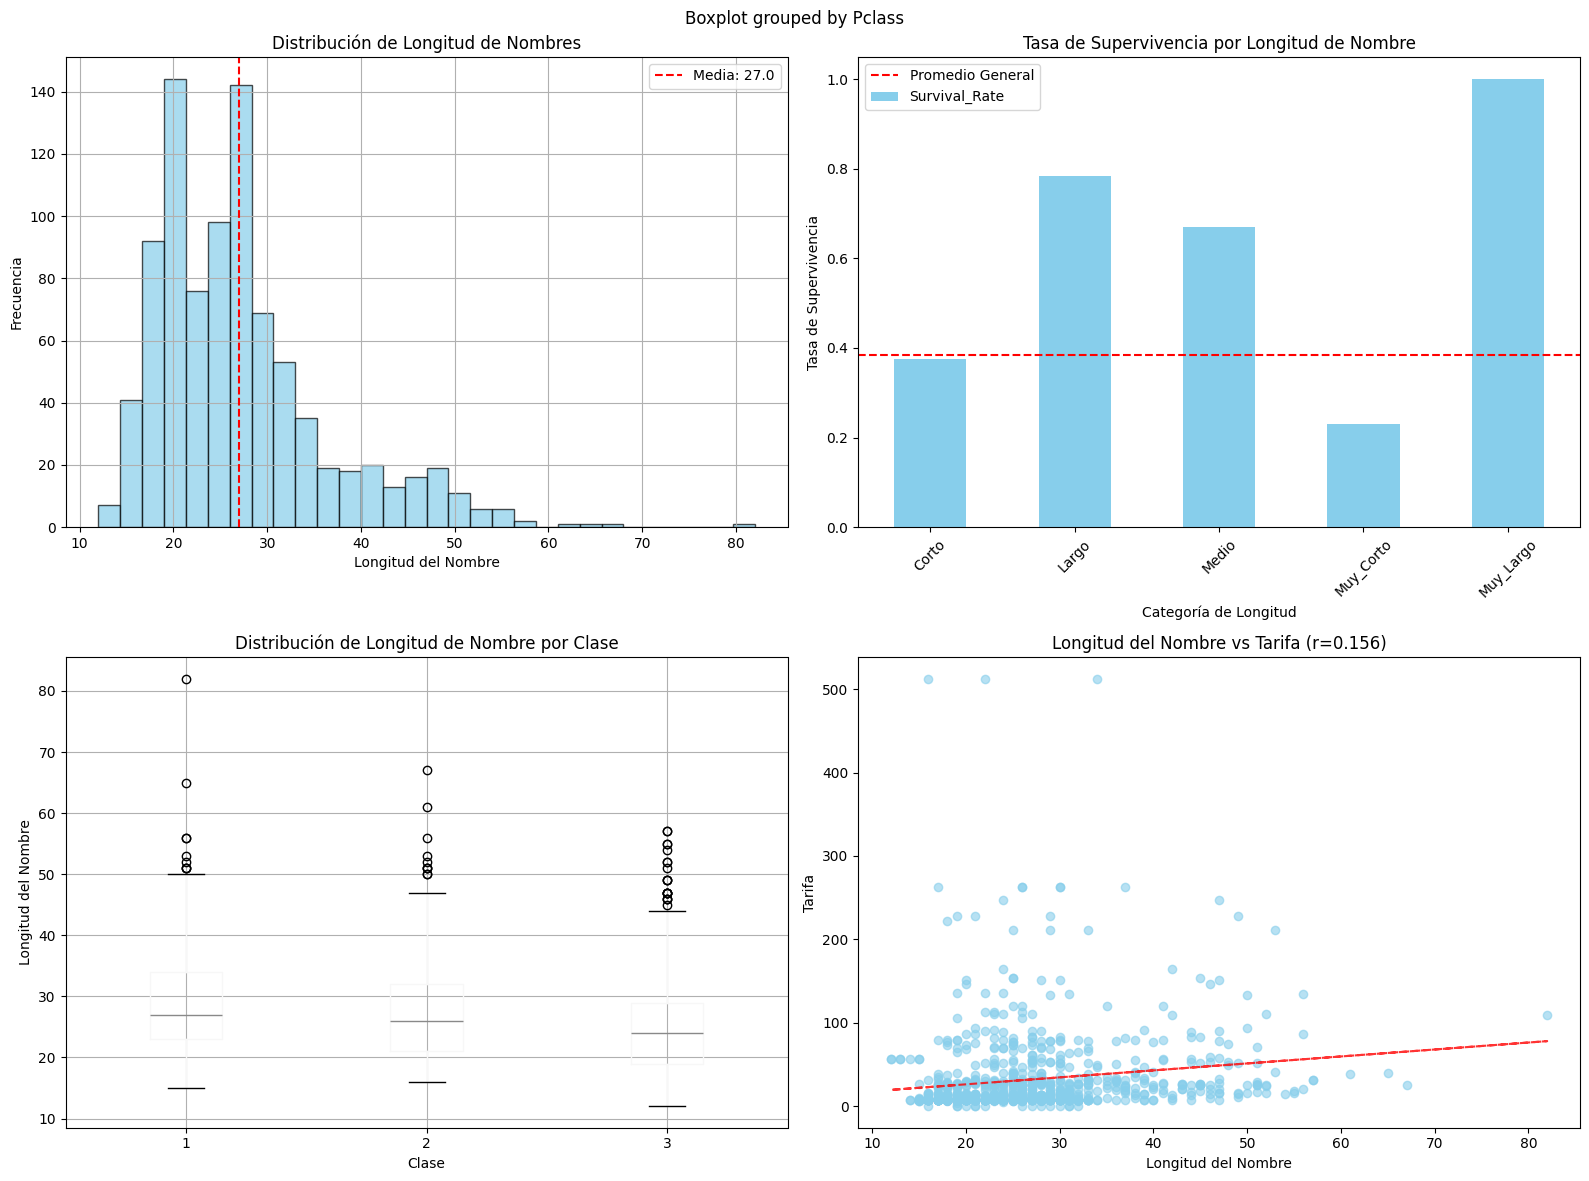


Análisis de calidad:
Valores faltantes: 0
Nombres con longitud 0: 0
Longitud mínima: 12
Longitud máxima: 82
Nombre más largo: Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)
Nombre más corto: Lam, Mr. Ali

Tasa de supervivencia por quintil de longitud de nombre:
                     Count  Survival_Rate
NameLength_Quintile                      
Q1                     204          0.221
Q2                     156          0.301
Q3                     197          0.320
Q4                     165          0.442
Q5                     169          0.675


In [37]:
def compute_name_length(name):
    """
    Calcula la longitud del nombre completo
    """
    if pd.isna(name) or not isinstance(name, str):
        return 0
    
    return len(str(name).strip())

# Aplicar la función
df['NameLength'] = df['Name'].apply(compute_name_length)

print("=== ANÁLISIS DE FEATURE: NAME LENGTH ===")
print(f"Estadísticas descriptivas:")
name_length_stats = df['NameLength'].describe().round(1)
print(name_length_stats)

print(f"\nEjemplos de nombres por longitud:")
print("Nombres cortos (<=20 caracteres):")
short_names = df[df['NameLength'] <= 20]['Name'].head(5)
for name in short_names:
    print(f"  {name} (longitud: {len(name)})")

print("\nNombres largos (>=60 caracteres):")
long_names = df[df['NameLength'] >= 60]['Name'].head(5)
for name in long_names:
    print(f"  {name} (longitud: {len(name)})")

# Crear categorías de longitud
def categorize_name_length(length):
    if length <= 20:
        return "Muy_Corto"
    elif length <= 35:
        return "Corto"
    elif length <= 50:
        return "Medio"
    elif length <= 65:
        return "Largo"
    else:
        return "Muy_Largo"

df['NameLength_Category'] = df['NameLength'].apply(categorize_name_length)

print(f"\nDistribución por categorías de longitud:")
name_cat_counts = df['NameLength_Category'].value_counts()
print(name_cat_counts)

if 'Survived' in df.columns:
    survival_by_name_length = df.groupby('NameLength_Category')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_name_length.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por categoría de longitud de nombre:")
    print(survival_by_name_length.sort_values('Survival_Rate', ascending=False))
    
    # Análisis por clase
    name_class_crosstab = pd.crosstab(df['Pclass'], df['NameLength_Category'], normalize='index').round(2)
    print(f"\nDistribución de longitud de nombre por clase (proporciones):")
    print(name_class_crosstab)
    
    # Correlación con tarifa
    name_fare_corr = df['NameLength'].corr(df['Fare'])
    print(f"\nCorrelación entre longitud del nombre y tarifa: {name_fare_corr:.3f}")
    
    # Análisis por título
    name_title_stats = df.groupby('Title')['NameLength'].agg(['count', 'mean', 'std']).round(1)
    print(f"\nEstadísticas de longitud de nombre por título:")
    print(name_title_stats)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Histograma de longitud de nombres
    df['NameLength'].hist(bins=30, ax=ax1, color='skyblue', alpha=0.7, edgecolor='black')
    ax1.axvline(df['NameLength'].mean(), color='red', linestyle='--', label=f'Media: {df["NameLength"].mean():.1f}')
    ax1.set_title('Distribución de Longitud de Nombres')
    ax1.set_xlabel('Longitud del Nombre')
    ax1.set_ylabel('Frecuencia')
    ax1.legend()
    
    # Supervivencia por categoría de longitud
    survival_by_name_length['Survival_Rate'].plot(kind='bar', ax=ax2, color='skyblue')
    ax2.set_title('Tasa de Supervivencia por Longitud de Nombre')
    ax2.set_xlabel('Categoría de Longitud')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    # Boxplot longitud de nombre por clase
    df.boxplot(column='NameLength', by='Pclass', ax=ax3)
    ax3.set_title('Distribución de Longitud de Nombre por Clase')
    ax3.set_xlabel('Clase')
    ax3.set_ylabel('Longitud del Nombre')
    
    # Scatter plot longitud vs tarifa
    ax4.scatter(df['NameLength'], df['Fare'], alpha=0.6, color='skyblue')
    ax4.set_xlabel('Longitud del Nombre')
    ax4.set_ylabel('Tarifa')
    ax4.set_title(f'Longitud del Nombre vs Tarifa (r={name_fare_corr:.3f})')
    
    # Línea de tendencia
    z = np.polyfit(df['NameLength'], df['Fare'], 1)
    p = np.poly1d(z)
    ax4.plot(df['NameLength'], p(df['NameLength']), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()

print(f"\nAnálisis de calidad:")
print(f"Valores faltantes: {df['NameLength'].isna().sum()}")
print(f"Nombres con longitud 0: {(df['NameLength'] == 0).sum()}")
print(f"Longitud mínima: {df['NameLength'].min()}")
print(f"Longitud máxima: {df['NameLength'].max()}")
print(f"Nombre más largo: {df.loc[df['NameLength'].idxmax(), 'Name']}")
print(f"Nombre más corto: {df.loc[df['NameLength'].idxmin(), 'Name']}")

# Análisis por quintiles
df['NameLength_Quintile'] = pd.qcut(df['NameLength'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

if 'Survived' in df.columns:
    survival_by_quintile = df.groupby('NameLength_Quintile')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_quintile.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por quintil de longitud de nombre:")
    print(survival_by_quintile)

##### Feature 10: TicketPrefix - Prefijo del ticket
Los prefijos de los tickets pueden indicar diferentes tipos de boletos, clases de servicio, o agencias de venta, lo que podría correlacionarse con patrones de supervivencia.

=== ANÁLISIS DE FEATURE: TICKET PREFIX ===
Distribución de prefijos de ticket:
TicketPrefix
Numeric     661
PC           60
CA           41
A_           25
STON_O       18
SOTON_OQ     15
SC_PARIS     11
W_C          10
SOC           5
FCC           5
C             5
LINE          4
SC_AH         3
PP            3
A             3
Name: count, dtype: int64

Ejemplos de tickets por prefijo:
Prefijo PC: ['PC 17599', 'PC 17601', 'PC 17569']
Prefijo CA: ['C.A. 24579', 'C.A. 31026', 'C.A. 34651']
Prefijo SC: ['SC 1748']
Prefijo Numeric: ['113803', '373450', '330877']

Distribución por categorías de prefijo:
TicketPrefix_Category
Numeric    661
Other      122
PC          60
CA          41
PP           3
A            3
SC           1
Name: count, dtype: int64

Tasa de supervivencia por categoría de prefijo de ticket:
                       Count  Survival_Rate
TicketPrefix_Category                      
SC                         1          1.000
PP                         3          0.667
PC 

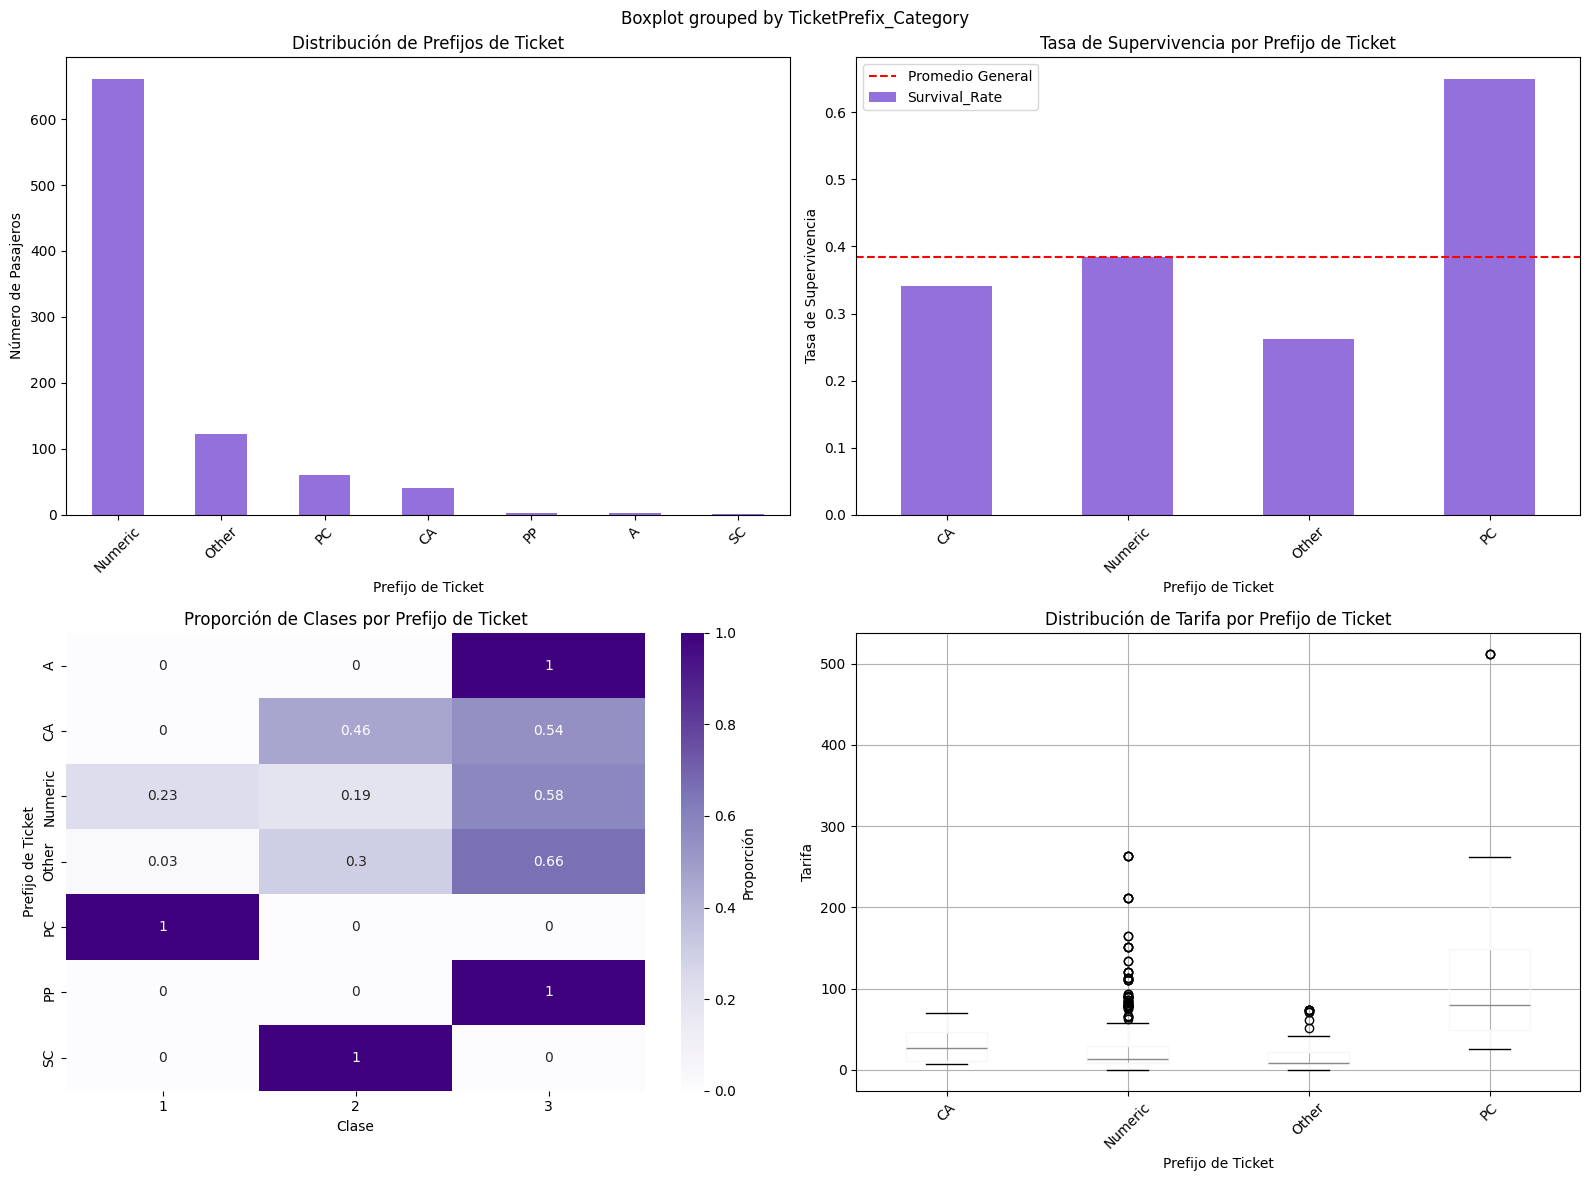


Análisis detallado de prefijos principales:

PC:
  Cantidad: 60
  Supervivencia: 0.650
  Tarifa media: 122.08
  Clases: {1: 60}

CA:
  Cantidad: 41
  Supervivencia: 0.341
  Tarifa media: 30.99
  Clases: {3: 22, 2: 19}

Numeric:
  Cantidad: 661
  Supervivencia: 0.384
  Tarifa media: 27.13
  Clases: {3: 382, 1: 152, 2: 127}

Análisis de calidad:
Prefijos únicos: 31
Prefijos 'Unknown': 0
Tickets numéricos: 661

Ejemplos de tickets diversos:
  A/5 21171 -> A_
  PC 17599 -> PC
  STON/O2. 3101282 -> STON_O
  113803 -> Numeric
  373450 -> Numeric
  330877 -> Numeric
  17463 -> Numeric
  349909 -> Numeric
  347742 -> Numeric
  237736 -> Numeric


In [38]:
def extract_ticket_prefix(ticket):
    """
    Extrae el prefijo del ticket (letras antes del primer número o espacio)
    """
    if pd.isna(ticket) or not isinstance(ticket, str):
        return "Unknown"
    
    ticket_clean = str(ticket).strip()
    if len(ticket_clean) == 0:
        return "Unknown"
    
    # Buscar el primer dígito o espacio
    import re
    
    # Extraer letras al inicio del ticket
    match = re.match(r'^([A-Za-z/\.]+)', ticket_clean)
    if match:
        prefix = match.group(1).upper()
        
        # Limpiar algunos prefijos comunes
        prefix = prefix.replace('.', '')
        prefix = prefix.replace('/', '_')
        
        # Si el prefijo es muy largo, tomar solo los primeros caracteres
        if len(prefix) > 10:
            prefix = prefix[:10]
            
        return prefix if prefix else "Numeric"
    
    # Si no hay letras al inicio, es un ticket numérico
    return "Numeric"

# Aplicar la función
df['TicketPrefix'] = df['Ticket'].apply(extract_ticket_prefix)

print("=== ANÁLISIS DE FEATURE: TICKET PREFIX ===")
print(f"Distribución de prefijos de ticket:")
prefix_counts = df['TicketPrefix'].value_counts()
print(prefix_counts.head(15))

print(f"\nEjemplos de tickets por prefijo:")
for prefix in ['PC', 'STON', 'CA', 'SC', 'Numeric']:
    if prefix in df['TicketPrefix'].values:
        examples = df[df['TicketPrefix'] == prefix]['Ticket'].head(3).tolist()
        print(f"Prefijo {prefix}: {examples}")

# Agrupar prefijos menos comunes
def categorize_ticket_prefix(prefix):
    # Prefijos más comunes que mantener separados
    common_prefixes = ['PC', 'CA', 'STON', 'SC', 'PP', 'WE', 'A', 'SO', 'Numeric']
    
    if prefix in common_prefixes:
        return prefix
    elif prefix == 'Unknown':
        return 'Unknown'
    else:
        return 'Other'

df['TicketPrefix_Category'] = df['TicketPrefix'].apply(categorize_ticket_prefix)

print(f"\nDistribución por categorías de prefijo:")
prefix_cat_counts = df['TicketPrefix_Category'].value_counts()
print(prefix_cat_counts)

if 'Survived' in df.columns:
    survival_by_prefix = df.groupby('TicketPrefix_Category')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_prefix.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por categoría de prefijo de ticket:")
    print(survival_by_prefix.sort_values('Survival_Rate', ascending=False))
    
    # Análisis por clase
    prefix_class_crosstab = pd.crosstab(df['TicketPrefix_Category'], df['Pclass'], margins=True)
    print(f"\nDistribución de prefijos por clase:")
    print(prefix_class_crosstab)
    
    # Análisis de tarifa por prefijo
    prefix_fare_stats = df.groupby('TicketPrefix_Category')['Fare'].agg(['count', 'mean', 'median']).round(2)
    prefix_fare_stats = prefix_fare_stats.sort_values('mean', ascending=False)
    print(f"\nEstadísticas de tarifa por prefijo de ticket:")
    print(prefix_fare_stats)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Distribución de prefijos
    prefix_cat_counts.plot(kind='bar', ax=ax1, color='mediumpurple')
    ax1.set_title('Distribución de Prefijos de Ticket')
    ax1.set_xlabel('Prefijo de Ticket')
    ax1.set_ylabel('Número de Pasajeros')
    ax1.tick_params(axis='x', rotation=45)
    
    # Supervivencia por prefijo
    survival_by_prefix_filtered = survival_by_prefix[survival_by_prefix['Count'] >= 10]  # Solo prefijos con suficientes datos
    survival_by_prefix_filtered['Survival_Rate'].plot(kind='bar', ax=ax2, color='mediumpurple')
    ax2.set_title('Tasa de Supervivencia por Prefijo de Ticket')
    ax2.set_xlabel('Prefijo de Ticket')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    # Heatmap prefijo vs clase
    prefix_class_pct = pd.crosstab(df['TicketPrefix_Category'], df['Pclass'], normalize='index').round(2)
    prefix_class_pct = prefix_class_pct[prefix_class_pct.sum(axis=1) > 0.01]  # Solo prefijos significativos
    sns.heatmap(prefix_class_pct, annot=True, cmap='Purples', ax=ax3, 
                cbar_kws={'label': 'Proporción'})
    ax3.set_title('Proporción de Clases por Prefijo de Ticket')
    ax3.set_xlabel('Clase')
    ax3.set_ylabel('Prefijo de Ticket')
    
    # Boxplot tarifa por prefijo
    # Solo prefijos con suficientes datos
    prefixes_to_plot = prefix_cat_counts[prefix_cat_counts >= 20].index.tolist()
    df_filtered = df[df['TicketPrefix_Category'].isin(prefixes_to_plot)]
    df_filtered.boxplot(column='Fare', by='TicketPrefix_Category', ax=ax4)
    ax4.set_title('Distribución de Tarifa por Prefijo de Ticket')
    ax4.set_xlabel('Prefijo de Ticket')
    ax4.set_ylabel('Tarifa')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Análisis detallado de prefijos específicos
print(f"\nAnálisis detallado de prefijos principales:")
for prefix in ['PC', 'CA', 'STON', 'Numeric']:
    if prefix in df['TicketPrefix_Category'].values:
        prefix_data = df[df['TicketPrefix_Category'] == prefix]
        if len(prefix_data) >= 10:
            print(f"\n{prefix}:")
            print(f"  Cantidad: {len(prefix_data)}")
            print(f"  Supervivencia: {prefix_data['Survived'].mean():.3f}")
            print(f"  Tarifa media: {prefix_data['Fare'].mean():.2f}")
            print(f"  Clases: {prefix_data['Pclass'].value_counts().to_dict()}")

print(f"\nAnálisis de calidad:")
print(f"Prefijos únicos: {df['TicketPrefix'].nunique()}")
print(f"Prefijos 'Unknown': {(df['TicketPrefix'] == 'Unknown').sum()}")
print(f"Tickets numéricos: {(df['TicketPrefix'] == 'Numeric').sum()}")

# Algunos ejemplos de tickets sin patrón claro
print(f"\nEjemplos de tickets diversos:")
diverse_tickets = df['Ticket'].drop_duplicates().head(10)
for ticket in diverse_tickets:
    prefix = extract_ticket_prefix(ticket)
    print(f"  {ticket} -> {prefix}")